# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

-----
**Описание данных:** В распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы:
* **сalls** — количество звонков,
* **minutes** — суммарная длительность звонков в минутах,
* **messages** — количество sms-сообщений,
* **mb_used** — израсходованный интернет-трафик в Мб,
* **is_ultra** — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

-----
**Задача:** Построить модель для задачи классификации с максимально большим значением *accuracy*, которая выберет подходящий тариф.

-----
**Цель:** Нужно довести долю правильных ответов по крайней мере до 0.75.

-----
**Содержание:**
1. [Открытие и изучение файла](#1)
2. [Разбивка данных на выборки](#2)
3. [Исследование модели](#3)
4. [Проверка модели на тестовой выборке](#4)
5. [Проверка модели на адекватность](#5)
6. [Общие выводы](#6)

## <a id=1>Открытие и изучение файла</a>

In [1]:
#Подгружаем необходимые библиотеки для работы с данными и машинного обучения
import warnings
import timeit
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Подгружаем дополнительные полезные библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
#Уберем warnings, чтобы не мешали
warnings.filterwarnings("ignore")

In [3]:
#Загружаем и проверяем файл с данными
try:
    data = pd.read_csv('C:/Users/kiril/OneDrive/Рабочий стол/Практикум/Проекты/Спринт 6. Машинное обучение/users_behavior.csv')
except:
    data = pd.read_csv('/datasets/users_behavior.csv')
    
data.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


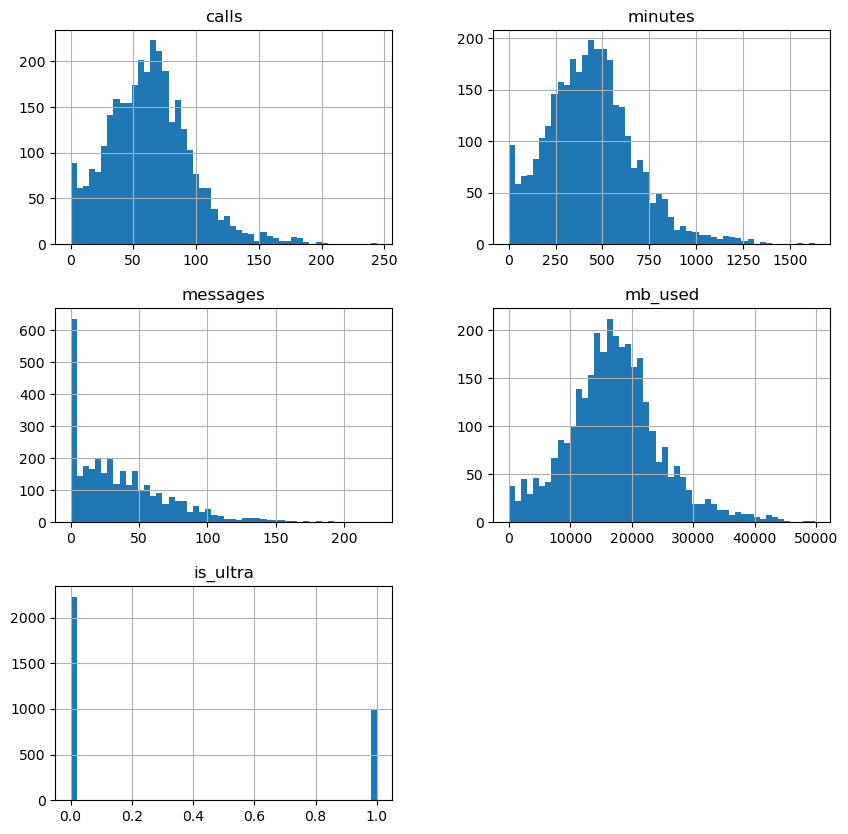

In [4]:
#Выведем информацию о датафрейме и гистограммы
data.info()
data.hist(figsize=(10,10), bins=50);

In [5]:
#Выведем описание всех столбцов в данных
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


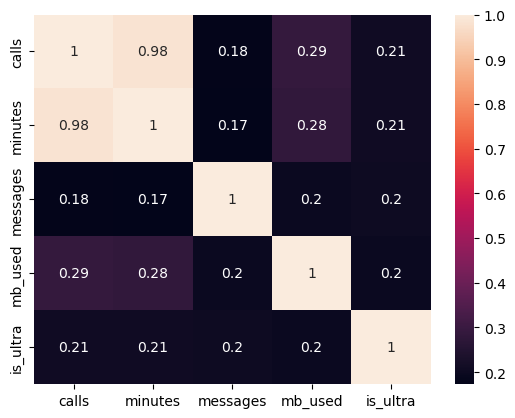

In [6]:
#Выведем тепловую карту, чтобы понять, какие параметры наибольшим образом коррелируют между собой
sns.heatmap(data.corr(), annot=True);

In [7]:
#Выведем теперь параметр VIF для поиска коллинеарных признаков 
vif_data = pd.DataFrame()
vif_data['feature'] = data.iloc[:,0:4].columns
vif_data['VIF'] = [variance_inflation_factor(data.iloc[:,0:4].values, i) for i in range(len(data.iloc[:,0:4].columns))]
vif_data

,feature,VIF
0,calls,129.350246
1,minutes,126.448586
2,messages,2.184385
3,mb_used,4.380105


**Выводы:**

1) Данные вглядят без вылетов, пропущенные значения отсутствуют;\
2) Большинство клиентов совершают до 70 звонков с суммарной продолжительностью менее 500 минут; \
3) Большое количество клиентов не склонны отправлять сообщения; \
4) В основном клиенты суммарно используют траффика менее 20 gb; \
5) К тарифу Смарт подключена большая часть клиентов; \
6) Между собой сильно вазимосвязаны 2 параметра: количество минут и звонков, что логично. Параметр VIF значительно больше 10 для этих двух параметров. Остальные параметры имеют слабую корреляцию.

## <a id=2>Разбивка данных на выборки</a>

Разделим имеющийся датафрейм на обучающую, валидационную и тестовую выборку в соотношении 60:20:20% соответственно. Обучающая выборка логично должна быть больше, чем тестовая и валидационная, а последние две в свою очередь желательно равны между собой.

In [8]:
data_train, data_valid_test = train_test_split(data, 
                                               test_size=0.4, 
                                               random_state=12345, 
                                               stratify=data['is_ultra'])
data_valid, data_test = train_test_split(data_valid_test, 
                                         test_size=0.5, 
                                         random_state=12345, 
                                         stratify=data_valid_test['is_ultra'])

#Проверим размеры выборок
print(data_train.shape)
print(data_valid.shape)
print(data_test.shape)

(1928, 5)
(643, 5)
(643, 5)


**Выводы:**

Данные разделены на три выборки: обучающую, валидационную и тестовую, - в соотношении 60:20:20%

## <a id=3>Исследование модели</a>

Логично, что ***целевой признак*** - это непосредственно тариф, ***остальные признаки*** - остальные параметры в данных. \
Пока что мы будем работать с обучающей и валидационной выборками, чтобы найти лучшую модель.

In [9]:
#Выделим целевой и остальные признаки
target_train = data_train['is_ultra']
features_train = data_train.drop('is_ultra', axis=1)
target_valid = data_valid['is_ultra']
features_valid = data_valid.drop('is_ultra', axis=1)

Далее создана функция, которая автоматически определяет лучший гиперпараметр для каждой модели. Идея такая: 
* берем сначала средний диапазон, например [10,100,10];
* если лучшее решение будет с гиперпараметром 100 (макс. зн-е), то соответственно произойдет увеличение диапазона до [100,1000,100]; 
* если лучшее решение будет с гиперпараметром 10 (мин. зн-е), то соответственно произойдет уменьшение диапазона до [1,10,1];

Цикл каждого из данных направлений заканчивается, пока лучший гиперпараметр не будет находиться в промежутке между мин. и макс. значениями (это очень быстро).
    
* далее допустим, что лучшее решение получилось с гиперпараметром 900 при диапазоне [100,1000,100]. Тогда цикл сокращает диапазон до [800,1000,10]. Далее гипрепараметр получился, допустим, 860. Тогда диапазон сокращается до [850,870,1]. А уже из этого диапазона выбирается лучшее значение;
* Итог: получается максимальная точность при нахождении лучшего решения для каждого способа (проверено по сравнению с ручным поиском нужного диапазона  и на графиках) при полной автоматизации подбора диапазона, при этом поиск не занимает большого количества времени из-за постепенного отсечения значений диапазона.

In [10]:
#Создадим функцию, которая будет находить лучший вариант в зависимости от выбора модели

def model_choice(kind_model, k, n, d):
#Начинаем отсчет времени
    start_time = timeit.default_timer()
#Ищем лучший вариант
    best_model = None
    best_accuracy = 0
    best_hyperparam = 0
    for i in range(k,n,d):
        if kind_model == DecisionTreeClassifier:
            model=kind_model(random_state=12345, max_depth=i)
        elif kind_model == RandomForestClassifier:
            model=kind_model(random_state=12345, n_estimators=i)
        elif kind_model == LogisticRegression:         
            model=kind_model(random_state=12345, solver='lbfgs', max_iter=i)
        model.fit(features_train,target_train)
        predictions = model.predict(features_valid)
        accuracy = model.score(features_valid,target_valid)  
        if accuracy > best_accuracy:
            best_model = model
            best_accuracy = accuracy
            best_hyperparam = i
#Заканчиваем подсчет времени
    end_time = timeit.default_timer() - start_time
    return best_model, best_accuracy, end_time, best_hyperparam

In [11]:
#Теперь создадим сводную таблицу со всеми лучшими моделями 

model_accuracy = []
model_time = []
model_hyperparam = []
GOAT_model = None
GOAT_accuracy = 0
for i in [DecisionTreeClassifier, RandomForestClassifier, LogisticRegression]:
    k = 10
    n = 100
    d = 10
    best_model, best_accuracy, end_time, best_hyperparam = model_choice(i, k, n, d)
    if best_hyperparam == n:
        while best_hyperparam == n:
            k = int(n)
            d = int(n)
            n = int(n * 10)
            best_model, best_accuracy, end_time, best_hyperparam = model_choice(i, k, n, d)
    if best_hyperparam == k:
        while best_hyperparam == k:
            n = int(k)
            d = int(k/10)
            k = int(k/10)
            best_model, best_accuracy, end_time, best_hyperparam = model_choice(i, k, n, d)
    while d > 1:
        n = int(best_hyperparam + d)
        k = int(n - d)
        d = int(d/10)
        best_model, best_accuracy, end_time, best_hyperparam = model_choice(i, k, n, d)  
    model_accuracy.append(best_accuracy)
    model_time.append(end_time)
    model_hyperparam.append(best_hyperparam)
    if GOAT_accuracy < best_accuracy:
        GOAT_model = best_model
    GOAT_accuracy = best_accuracy

pivot_model = pd.DataFrame({'Точность' : model_accuracy, 
                            'Время' : model_time, 
                            'Гиперпараметр' : model_hyperparam}, 
                           index=['Дерево решений', 'Случайный лес', 'Регрессия'])

print('Лучшая модель:', GOAT_model)
pivot_model.round(3)

#P.S. GOAT - величайший (Great of All Time)

Лучшая модель: RandomForestClassifier(n_estimators=61, random_state=12345)


,Точность,Время,Гиперпараметр
Дерево решений,0.802,0.045,8
Случайный лес,0.812,1.967,61
Регрессия,0.745,0.159,79


In [12]:
#Сделаем отдельную функцию для графиков
def model_graf(kind_model, k, n, d):
    all_accuracy_train = []
    all_accuracy_valid = []
    x = []
    for i in range(k,n,d):
        if kind_model == DecisionTreeClassifier:
            model=kind_model(random_state=12345, max_depth=i)
        elif kind_model == RandomForestClassifier:
            model=kind_model(random_state=12345, n_estimators=i)
        elif kind_model == LogisticRegression:         
            model=kind_model(random_state=12345, solver='lbfgs', max_iter=i)
        model.fit(features_train,target_train)
        predictions = model.predict(features_valid)
        accuracy_train = model.score(features_train,target_train) 
        accuracy = model.score(features_valid,target_valid) 
        all_accuracy_train.append(accuracy_train)
        all_accuracy_valid.append(accuracy)
        x.append(i)
        if (kind_model == DecisionTreeClassifier) and (i==3):
            plt.figure(figsize=(12,5))
            plot_tree(model, 
                      feature_names=features_valid.columns.values, 
                      class_names=['Smart','Ultra'],
                      filled=True,
                      fontsize = 7,
                      max_depth = 3)
    plt.figure(figsize=(12,5))
    plt.plot(x, all_accuracy_train, label='Тренировочная')
    plt.plot(x, all_accuracy_valid, label='Валидационная')
    plt.title(kind_model)
    plt.xticks(np.arange(k,n,d))
    plt.xlabel('Гиперпараметр')
    plt.ylabel('Точность')
    plt.legend()
    return accuracy

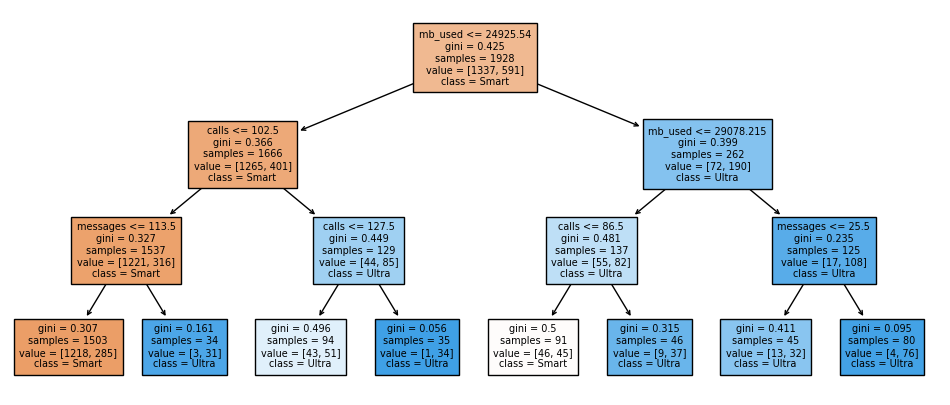

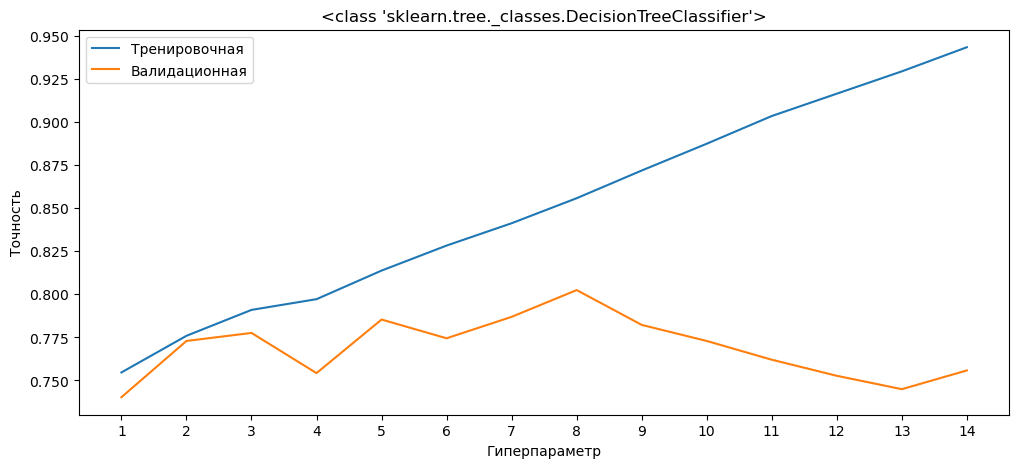

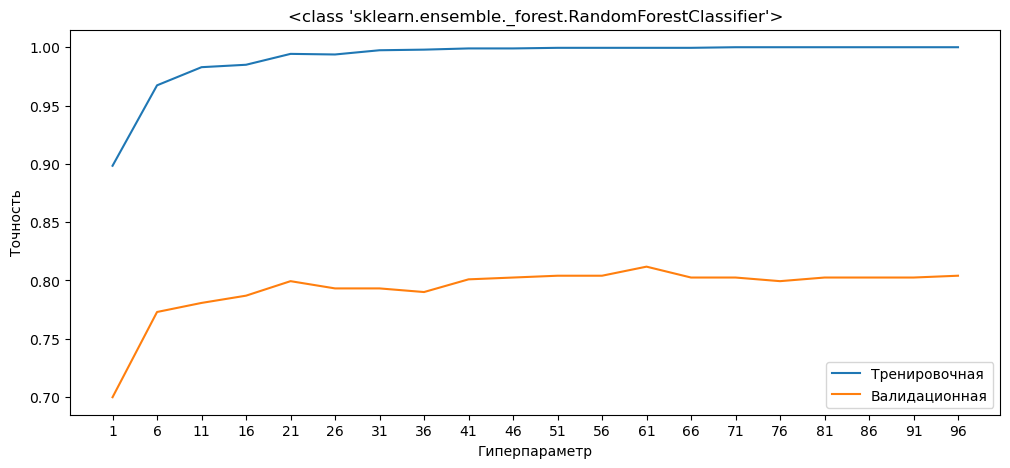

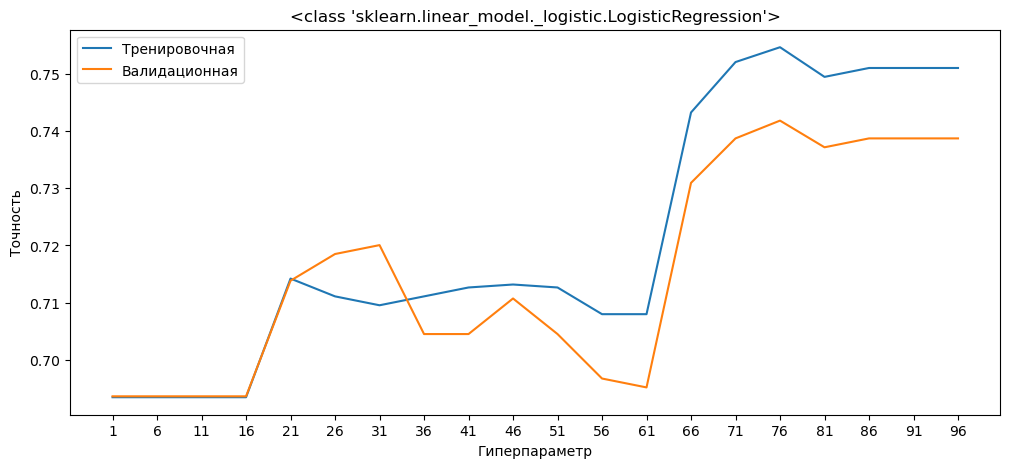

In [13]:
#Построим графики, зная, какой лучший гиперпараметр
for i in [DecisionTreeClassifier, RandomForestClassifier, LogisticRegression]:
    if i == DecisionTreeClassifier:
        k = 1
        n = 15
        d = 1
    else:
        k = 1
        n = 100
        d = 5
    model_graf(i, k, n, d)

**Выводы:**

Были рассмотрены 3 вида моделей:
* Дерево решений
* Случайный лес
* Регрессия

Для всех моделей лучшее решение было найдено достаточно быстро, что может говорить о достаточно быстрой предстоящей работе каждой модели с тестовой выборкой. \
Согласно величине точности, лучшая модель для использования - это случайный лес с максимальным количеством деревьев 61.
Стоит отметить, что регрессия значичетельно хуже остальных видов моделей. 

## <a id=4>Проверка модели на тестовой выборке</a>

In [14]:
#Используем лучшую модель для тестовой выборки
target_test = data_test['is_ultra']
features_test = data_test.drop('is_ultra', axis=1)

start_time = timeit.default_timer()

predictions = GOAT_model.predict(features_test)
train_accuracy = GOAT_model.score(features_test, target_test)
end_time = timeit.default_timer() - start_time
print(f'Точность тестовой выборки: {round(train_accuracy, 3)}')
print(f'Время расчета: {round(end_time, 3)}')

Точность тестовой выборки: 0.801
Время расчета: 0.027


In [15]:
#Теперь попробуем обучить лучшую модель на объединенных тренировочной и валидацонной выборках
data_train_valid = pd.concat([data_train, data_valid])
target_train_valid = data_train_valid['is_ultra']
features_train_valid = data_train_valid.drop('is_ultra', axis=1)

GOAT_model_new = GOAT_model.fit(features_train_valid, target_train_valid)

start_time = timeit.default_timer()

predictions = GOAT_model_new.predict(features_test)
train_accuracy = GOAT_model_new.score(features_test, target_test)
end_time = timeit.default_timer() - start_time
print(f'Точность тестовой выборки: {round(train_accuracy, 3)}')
print(f'Время расчета: {round(end_time, 3)}')

Точность тестовой выборки: 0.832
Время расчета: 0.026


**Выводы:**

При использовании модели, показавшей себя лучшим образом на валидационной выборке, точность на тестовой выборке составляет 0.801, что выше значения точности, которого необходимо было достичь по заданию (0.75). При обучении модели сразу на объединенных тренировочной и валидационных выборках результат получился еще лучше и составил 0.832. Время расчета небольшое (<0.1 сек).

## <a id=5>Проверка модели на адекватность</a>

Для проверки адекватности модели используем: 

* матрицу путаницы
* F-меру
* сравнение с результатами использования базовой модели DummyClassifier()

In [16]:
#Построим матрицу путаницы
from sklearn.metrics import confusion_matrix
confusion_matrix(target_test, predictions)

array([[414,  32],
       [ 76, 121]], dtype=int64)

In [17]:
#Создадим датафрейм с точностью нахождения тарифов Смарт и Ультра
confusion = pd.DataFrame({'1_pred' : [392, 48], 
                            '0_pred' : [90,113]}, 
                           index=['1_actual', '0_actual'])

confusion['sum_mean'] = confusion['1_pred'] + confusion['0_pred']
confusion['1_pred'] = confusion['1_pred'] / confusion['sum_mean']
confusion['0_pred'] = confusion['0_pred'] / confusion['sum_mean']
confusion.round(3)

#P.S. Уже после в интернете нашел, что можно было это сделать с помощью plot_confusion_matrix scikit-learn

,1_pred,0_pred,sum_mean
1_actual,0.813,0.187,482
0_actual,0.298,0.702,161


Получается, что процент правильности определения тарифа Смарт ниже (70.2%), чем по тарифу Ультра (81.3%). \
По выбранной модели точность прогноза тарифа Смарт недостаточно высокая.    

In [18]:
#Найдем F-меру полученной модели
from sklearn.metrics import f1_score
round(f1_score(target_test, predictions), 3)

0.691

Аналогичный вывод можно сделать и по F-мере, она недостаточно высокая.

In [19]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=0)
dummy_clf.fit(features_train,target_train)
round(dummy_clf.score(features_test, target_test), 3)

0.694

Выбранная модель имеет точность выше, чем у базовой модели. Это может говорить о том, что она достаточно адекватно работает и все-таки ищет связь между целевым признаком и остальными. 

**Выводы:**

Модель проверена на адекватность работы с помощью трех параметров:
* По матрице путаницы удалость выяснить, что прогноз по тарифу Смарт недостаточно высок и меньше, чем по тарифу Ультра;
* F-мера показывает, что модель недостаточно точна;
* При сравнении с точностью базовой модели удалось понять, что выбранная модель работает адекватно

## <a id=6>Общие выводы</a>

**1. Выводы по данным**:
* Данные выглядят без вылетов, пропущенные значения отсутствуют;
* Большинство клиентов совершают до 70 звонков с суммарной продолжительностью менее 500 минут; 
* Большое количество клиентов не склонны отправлять сообщения; 
* В основном клиенты суммарно используют траффика менее 20 gb; 
* К тарифу Смарт подключена большая часть клиентов;
* Между собой сильно вазимосвязаны 2 параметра: количество минут и звонков, что логично. Параметр VIF значительно больше 10 для этих двух параметров. Остальные параметры имеют слабую корреляцию.
------

**2. Разбивка данных на выборки**:

Данные разделены на три выборки: обучающую, валидационную и тестовую, - в соотношении 60:20:20% 

------

**3. Исследование моделей**:

Были рассмотрены 3 вида моделей:
* Дерево решений
* Случайный лес
* Регрессия

Для всех моделей лучшее решение было найдено достаточно быстро, что может говорить о достаточно быстрой предстоящей работе каждой модели с тестовой выборкой. \
Согласно величине точности, лучшая модель для использования - это случайный лес с максимальным количеством деревьев 61.
Стоит отметить, что регрессия значительно хуже остальных видов моделей. 

------

**4. Проверка модели на тестовой выборке**:

При использовании модели, показавшей себя лучшим образом на валидационной выборке, точность на тестовой выборке составляет 0.801, что выше значения точности, которого необходимо было достичь по заданию (0.75). При обучении модели сразу на объединенных тренировочной и валидационных выборках результат получился еще лучше и составил 0.832. Время расчета небольшое (<0.1 сек).

------

**5. Проверка модели на адекватность**:

Модель проверена на адекватность работы с помощью трех параметров:
* По матрице путаницы удалость выяснить, что прогноз по тарифу Смарт недостаточно высок и меньше, чем по тарифу Ультра;
* F-мера показывает, что модель недостаточно точна;
* При сравнении с точностью базовой модели удалось понять, что выбранная модель работает адекватно